# PPMT Method

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.proj as gpd
import os

## Initialization

Simulation of a Reference data set on a Grid

In [3]:
grd = gl.DbGrid.create(x0=[0.0,0.0], dx=[0.01,0.01], nx=[100,100])

# Simulate two independent Gaussian Random variables
model1 = gl.Model.createFromParam(gl.ECov.GAUSSIAN, range=0.2, sill=1.0)
err = gl.simtub(None, dbout = grd, model = model1, nbsimu = 1)
grd.setName("Simu","Y1")

model2 = gl.Model.createFromParam(gl.ECov.EXPONENTIAL, range=0.1, sill=1.0)
err = gl.simtub(None, dbout = grd, model = model2, nbsimu = 1)
grd.setName("Simu","Y2")

# Non linear transform
grd["Z"] = grd["Y1"] * grd["Y1"] + 0.5 * grd["Y1"] + 0.2 * grd["Y2"]

In [4]:
grd["Y1.NS"] = gl.VH.normalScore(grd["Y1"])
grd["Z.NS"] = gl.VH.normalScore(grd["Z"])

In [5]:
grd.deleteColumns(["Y1","Y2","Z"])
grd.setName("Y1.NS","Y1")
grd.setName("Z.NS","Y2")

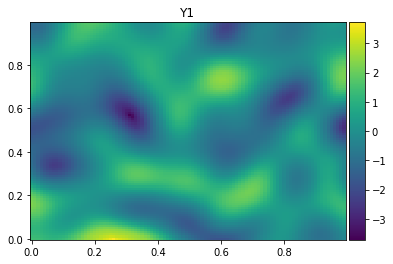

In [6]:
ax = gp.grid(grd,name="Y1",title="Y1")

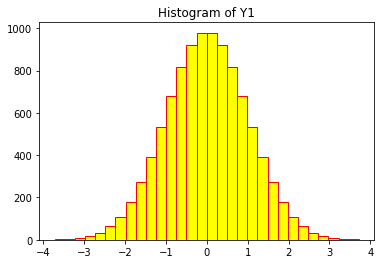

In [7]:
ax = gp.hist(grd,name="Y1",title="Histogram of Y1")

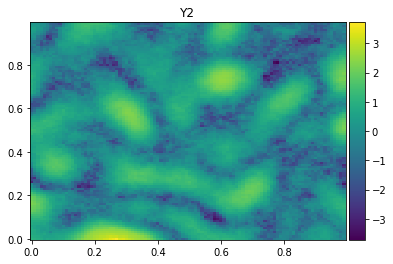

In [8]:
ax = gp.grid(grd,name="Y2",title="Y2")

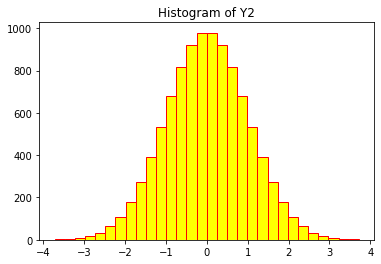

In [9]:
ax = gp.hist(grd,name="Y2",title="Histogram of Y2")

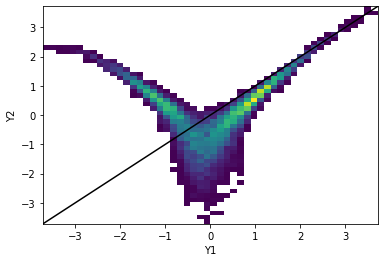

In [10]:
ax = gp.correlation(grd,namex="Y1",namey="Y2",diagLine=True)

Lognormal transformation

In [11]:
m_1 = 1.0; sigma_1 = 0.25
m_2 = 0.5; sigma_2 = 0.5
grd["Z1"] = m_1 * np.exp(sigma_1 * grd["Y1"] - 1/2 * sigma_1 * sigma_1 )
grd["Z2"] = m_2 * np.exp(sigma_2 * grd["Y2"] - 1/2 * sigma_2 * sigma_2 )

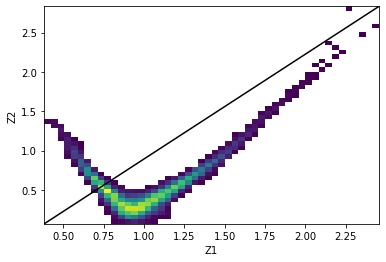

In [12]:
ax = gp.correlation(grd, namex = "Z1", namey = "Z2", diagLine=True)

In [13]:
dum = grd.statistics(["Z*","Y*"],opers=gl.EStatOption.fromKeys(["MINI","MAXI","MEAN","STDV"]))

                 MINI      MAXI      MEAN      STDV
Z1             0.382     2.456     1.000     0.254
Z2             0.069     2.833     0.500     0.266
Y1            -3.719     3.719     0.000     0.999
Y2            -3.719     3.719     0.000     0.999
 

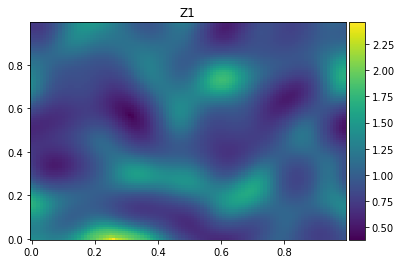

In [14]:
ax=gp.grid(grd, name = "Z1", title="Z1")

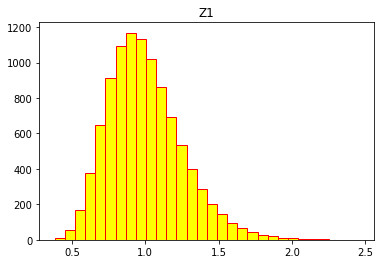

In [15]:
ax = gp.hist(grd, name="Z1", title="Z1")

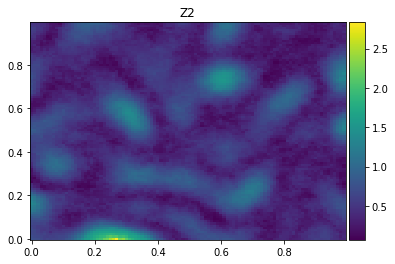

In [16]:
ax=gp.grid(grd, name = "Z2", title="Z2")

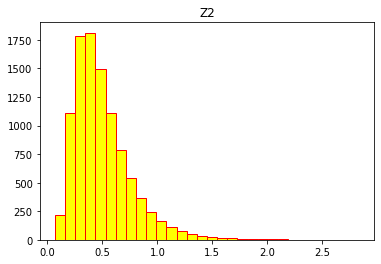

In [17]:
ax = gp.hist(grd, name="Z2", title="Z2")

## Extraction of a data set

In [18]:
nump  = 500
data = gl.Db.createSamplingDb(grd, number=nump, names = ["x1", "x2", "Z1", "Z2"])

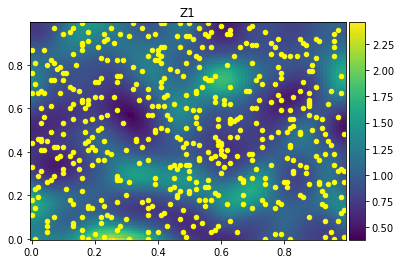

In [19]:
ax = gp.grid(grd,name="Z1")
ax = gp.point(data,color="yellow",ax=ax)

Normal score

In [20]:
data["Z1.NS"] = gl.VH.normalScore(data["Z1"])
data["Z2.NS"] = gl.VH.normalScore(data["Z2"])
data.setName("Z1.NS","Y1")
data.setName("Z2.NS","Y2")

In [21]:
dum = data.statistics(["Z*","Y*"],opers=gl.EStatOption.fromKeys(["MINI","MAXI","MEAN","STDV"]))

                 MINI      MAXI      MEAN      STDV
Z1             0.524     2.035     0.999     0.253
Z2             0.115     1.946     0.500     0.255
Y1            -2.879     2.879     0.000     0.989
Y2            -2.879     2.879     0.000     0.989
 

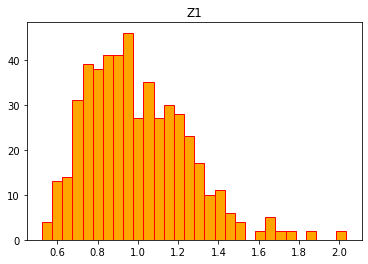

In [22]:
ax = gp.hist(data, "Z1", color="orange")

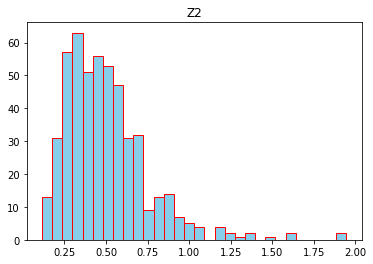

In [23]:
ax = gp.hist(data, "Z2", color="skyblue")

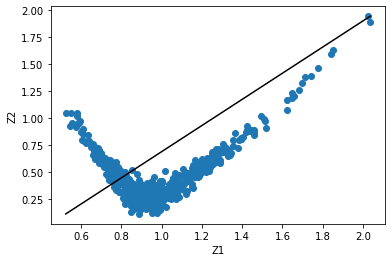

In [24]:
ax = gp.correlation(data, namex="Z1", namey="Z2", diagLine=True, asPoint=True)

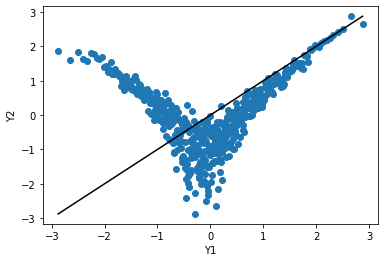

In [25]:
ax = gp.correlation(data, namex = "Y1", namey = "Y2", diagLine=True, asPoint=True)

## Implementing PPMT

Extracting the vector of data values

In [26]:
X = data["Y*"]
Xmat = gl.MatrixRectangular.createFromVVD(X)

Launching PPMT and fitting it on the vector of Input data

In [29]:
ppmt = gl.PPMT.create(ndir=10, niter=100, alpha=2., method="vdc")
err = ppmt.fit(Xmat, False)

Evolution of the Index

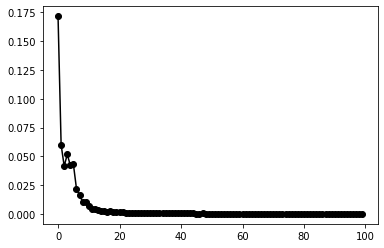

In [33]:
ln_index = ppmt.getSerieScore()
ax = gp.curve(ln_index, icas=2, marker='o')

Final results (non correlated variables)

In [34]:
iuid = data.addColumns(Xmat.getValues(), radix="U")
dum = data.statistics(["Y*","U-*"],opers=gl.EStatOption.fromKeys(["MINI","MAXI","MEAN","STDV"]))

                 MINI      MAXI      MEAN      STDV
Y1            -2.879     2.879     0.000     0.989
Y2            -2.879     2.879     0.000     0.989
U-1           -2.755     2.897     0.000     0.989
U-2           -2.804     2.915     0.000     0.989
 

Initial Gaussian variables

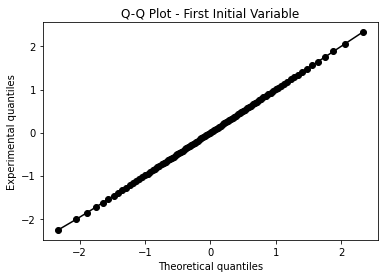

In [35]:
probas = np.arange(1,101) / (100 + 1)
q1 = gl.VH.quantiles(X[:,0], probas)
q2 = gl.VH.qnormVec(probas)
ax = gp.curve(q2, q1, marker='o',title="Q-Q Plot - First Initial Variable",
              xlabel = "Theoretical quantiles", ylabel = "Experimental quantiles")

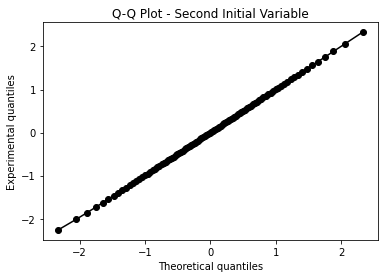

In [36]:
probas = np.arange(1,101) / (100 + 1)
q1 = gl.VH.quantiles(X[:,1], probas)
q2 = gl.VH.qnormVec(probas)
ax = gp.curve(q2, q1, marker='o',title="Q-Q Plot - Second Initial Variable",
              xlabel = "Theoretical quantiles", ylabel = "Experimental quantiles")

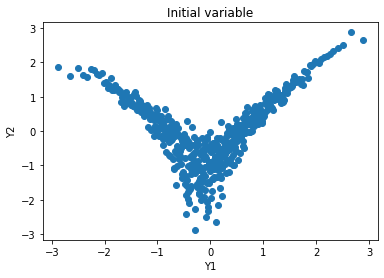

In [37]:
ax = gp.correlation(data,"Y1","Y2", title = "Initial variable", asPoint=True) 

Transformed Gaussian variables

In [38]:
U = data["U*"]

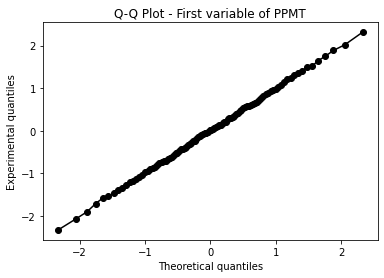

In [39]:
probas = np.arange(1,101) / (100 + 1)
q1 = gl.VH.quantiles(U[:,0], probas)
q2 = gl.VH.qnormVec(probas)
ax = gp.curve(q2, q1, marker='o', title = "Q-Q Plot - First variable of PPMT",
              xlabel = "Theoretical quantiles", ylabel = "Experimental quantiles")

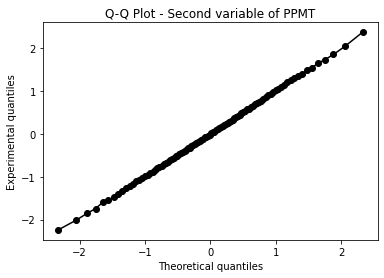

In [40]:
probas = np.arange(1,101) / (100 + 1)
q1 = gl.VH.quantiles(U[:,1], probas)
q2 = gl.VH.qnormVec(probas)
ax = gp.curve(q2, q1, marker='o', title = "Q-Q Plot - Second variable of PPMT",
              xlabel = "Theoretical quantiles", ylabel = "Experimental quantiles")

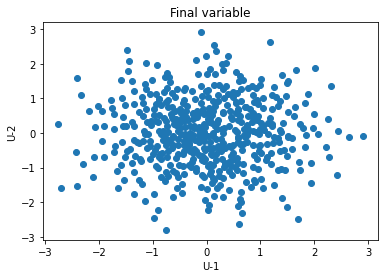

In [41]:
ax = gp.correlation(data, "U-1", "U-2", title = "Final variable", asPoint=True)

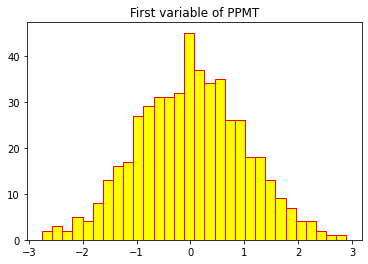

In [42]:
ax = gp.hist(data,"U-1", title="First variable of PPMT")

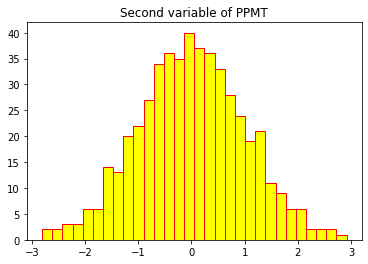

In [43]:
ax = gp.hist(data,"U-2", title="Second variable of PPMT")